In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
import tmdbsimple as tmdb
from itertools import chain
import statistics as stat
import math
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

## 1. Loading dataset ###

In [2]:
dataset = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [3]:
Actors = pd.read_csv('Saved_Datasets/Actorsv3Dataset.csv')

In [4]:
Actors.iloc[0:3]

,tmdb_id,Name,date,total_tenure,nb_total_movies,movies_in_dataset,Realease_date_of_movies_in_dataset,Actors_tenure_in_movies
0,15295,Vicky Haughton,"['2000', '2010']",11,5,['Whale Rider'],['2003'],[4]
1,16940,Jeremy Irons,"['1974', '2016']",43,90,"['Kingdom of Heaven', 'Eragon', 'Dungeons & Dr...","['2005', '2006', '2000', '2008', '2011', '2012...","[32, 33, 27, 35, 38, 39, 40, 43, 43]"
2,41087,Leslie Mann,"['1996', '2016']",21,31,"['Knocked Up', 'I Love You Phillip Morris', '1...","['2007', '2009', '2009', '2009', '2011', '2011...","[12, 14, 14, 14, 16, 16, 15, 17, 19, 19]"


In [5]:
dataset.head(5)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,actor_names,actors_ids,actors_tenures,total_tenure,average_tenure,Metacritic,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...","[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.20,90,2.639,4
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,"['Björk', 'Catherine Deneuve', 'David Morse', ...","[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.60,61,2.127,3
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...","[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.00,63,2.639,4
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Kill Bill: Vol. 1,Quentin Tarantino,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...","[140, 589, 2535, 139, 141]","[12, 26, 15, 17, 39]",109,21.80,69,2.639,4
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Jarhead,Sam Mendes,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...","[133, 134, 1350483, 155]","[11, 14, 0, 12]",37,9.25,58,0.346,2


## 2. Data exploration ##

### 2.1 Determine distribution actors total tenure ###

In [14]:
#Extract list of different tenures
all_act_tenures = list(Actors['total_tenure'])

diff_act_tenures = list(set(all_act_tenures))

freqTenure = []
for i in diff_act_tenures:
    freqTenure.append(all_act_tenures.count(i))

print(freqTenure)    
print(diff_act_tenures)   

[48, 342, 52, 76, 90, 97, 99, 102, 121, 127, 126, 164, 159, 143, 143, 141, 145, 150, 150, 104, 110, 121, 132, 110, 103, 106, 88, 78, 78, 75, 80, 80, 66, 64, 68, 59, 53, 53, 57, 38, 33, 35, 22, 31, 27, 23, 20, 27, 25, 21, 18, 16, 15, 13, 11, 11, 10, 16, 8, 4, 8, 5, 13, 4, 2, 2, 8, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 72, 74, 76, 78, 79, 80, 82, 83, 92, 98, 102, 117]


In [122]:
print(Actors[Actors['total_tenure'] == 102]) #James Russel 1915-2016 2movies -----> The boy  2016 1movie
print(Actors[Actors['total_tenure'] == 117]) #Shohreh Aghdashloo 1900-2016 28 movies ----> 1976-2016 26 movies 
print(Actors[Actors['total_tenure'] == 98]) #Fredro Starr 1918-2015 14 movies ---> 1993-2015 13 movies
print(Actors[Actors['total_tenure'] == 92]) #William Black 2009 2 movies -------> 2009 1 movies
print(Actors[Actors['total_tenure'] == 83]) #Norma Shearer 1920-2002 49 movies ------> 1919-1942 45 movies (Pas pour celui dans lequel on a dans le dataset)
print(Actors[Actors['total_tenure'] == 82]) #Barbara E. Robertson 1934-2015 4 movies -----> 2001-2015 3 movies
print(Actors[Actors['total_tenure'] == 80]) # Mary McCormack 1937-2016 28 movies ----> 1995-2016 27 movies
                                        #Ronald Reagan 1937-2016 85 movies ---> 1937-1964 63 films
print(Actors[Actors['total_tenure'] == 79]) #Michael Moreland 1936-2014 3 movies ----> 1999-2014 2 movies
                                        # Tom Payne 1937-2015 12 movies ---> 2007 - 2015 11 movies
print(Actors[Actors['total_tenure'] == 78])  #Jackie Long 1938-2015 14 movies   ---> 2005-2015 13 movies
print(Actors[Actors['total_tenure'] == 76])  #The kids stay in the picture (2002) mais déja mort 
print(Actors[Actors['total_tenure'] == 74]) #Pour un film ou il est déja mort
print(Actors[Actors['total_tenure'] == 72]) # Juste !

      tmdb_id           Name           date  total_tenure  nb_total_movies  \
1802  1029403  James Russell  [1915,  2016]           102                2   

     movies_in_dataset Realease_date_of_movies_in_dataset  \
1802       ['The Boy']                           ['2016']   

     Actors_tenure_in_movies  
1802                   [102]  
      tmdb_id                Name           date  total_tenure  \
2437    21041  Shohreh Aghdashloo  [1900,  2016]           117   

      nb_total_movies   movies_in_dataset Realease_date_of_movies_in_dataset  \
2437               28  ['The Lake House']                           ['2006']   

     Actors_tenure_in_movies  
2437                   [107]  
      tmdb_id          Name           date  total_tenure  nb_total_movies  \
1386    59568  Fredro Starr  [1918,  2015]            98               14   

            movies_in_dataset Realease_date_of_movies_in_dataset  \
1386  ['Save the Last Dance']                           ['2001']   

     Actor

In [123]:
Actors[Actors['Name']=='Shohreh Aghdashloo']

,tmdb_id,Name,date,total_tenure,nb_total_movies,movies_in_dataset,Realease_date_of_movies_in_dataset,Actors_tenure_in_movies
2437,21041,Shohreh Aghdashloo,"[1900, 2016]",117,28,['The Lake House'],['2006'],[107]


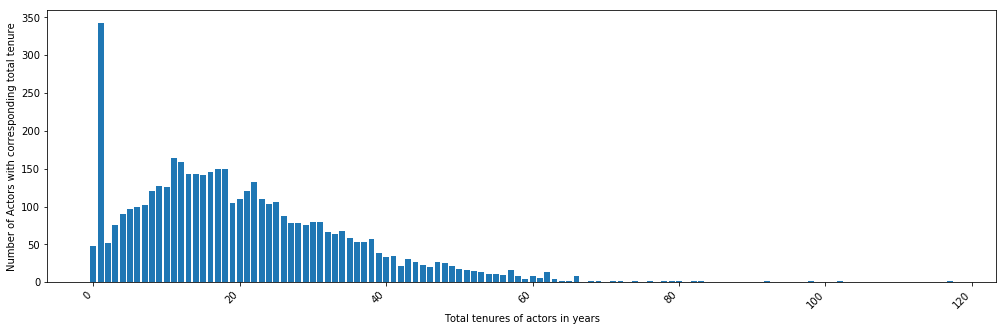

In [42]:
plt.bar(diff_act_tenures, freqTenure, align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Total tenures of actors in years');
plt.ylabel('Number of Actors with corresponding total tenure');
plt.savefig('images/tot_tenures_frequency_distri.png', dpi=300, bbox_inches='tight')

### 2.2 Distribution movies tenures ###

In [16]:
all_sum_tenures = list(dataset['total_tenure'])
diff_all_sum_tenures = list(set(all_sum_tenures))

freqSumtenure = []
for i in diff_all_sum_tenures:
    freqSumtenure.append(all_sum_tenures.count(i))
    
print(diff_all_sum_tenures)    
print(freqSumtenure)

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 175, 176, 178, 179, 180, 181, 183, 190, 196, 201, 202, 205, 207, 212, 219, 233]
[2, 2, 4, 4, 6, 3, 5, 3, 1, 3, 5, 4, 4, 3, 2, 2, 5, 2, 6, 4, 5, 3, 7, 7, 3, 5, 6, 3, 9, 9, 9, 5, 6, 12, 11, 11, 15, 9, 20, 16, 14, 13, 11, 15, 18, 18, 14, 13, 15, 22, 11, 19, 26

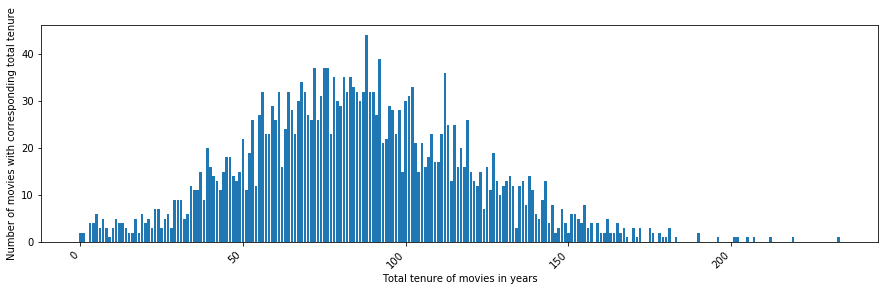

In [8]:
fig=plt.figure(figsize=(15, 4))

plt.bar(diff_all_sum_tenures, freqSumtenure, align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Total tenure of movies in years');
plt.ylabel('Number of movies with corresponding total tenure');
plt.savefig('images/sum_tenures_frequency_distri.png', dpi=300, bbox_inches='tight')

In [18]:
all_average_tenures = list(dataset['average_tenure'])
diff_all_average_tenures = list(set(all_average_tenures))
diff_all_average_tenures = sorted(diff_all_average_tenures)

freqAvgtenure = []
for i in diff_all_average_tenures:
    freqAvgtenure.append(all_average_tenures.count(i))

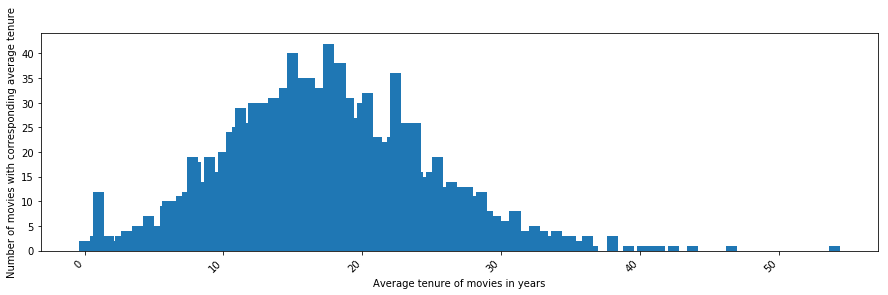

In [19]:
fig=plt.figure(figsize=(15, 4))
plt.bar(diff_all_average_tenures, freqAvgtenure, align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Average tenure of movies in years');
plt.ylabel('Number of movies with corresponding average tenure');
plt.savefig('images/avg_tenures_frequency_distri.png', dpi=300, bbox_inches='tight')

## 3. Data exploitation ##

### 3.1 Compute Weight matrix ###

In [5]:
#W = np.ndarray(shape=(10, 10), dtype=int)
W = np.ndarray(shape=(len(df_ten), len(df_ten)), dtype=int)
for i in range(0,len(df_ten)):
    for j in range(i,len(df_ten)):
        W[i][j] = abs(df_ten['total tenures'][i]-df_ten['total tenures'][j])

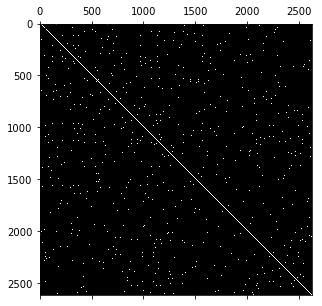

In [9]:
bigger = W.transpose() > W
W = W - W*bigger + W.transpose()*bigger
np.fill_diagonal(W, 0)
plt.spy(W)

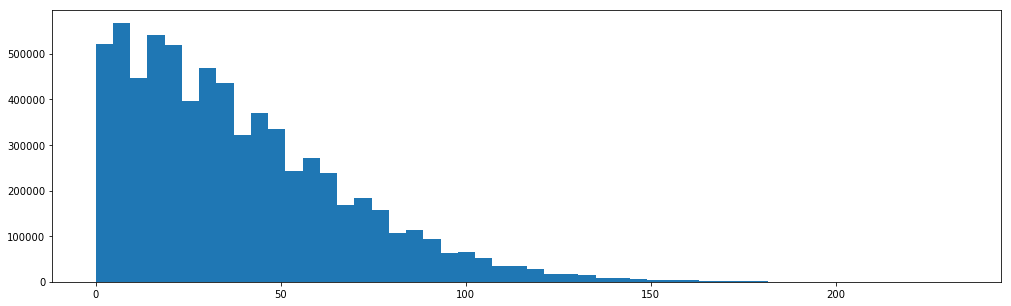

In [104]:
plt.hist(W.reshape(-1),bins=50);

### 3.2 Gaussian Normalization of W

In [10]:
sigma = np.std(W)
print(sigma)
mu = np.mean(W)
print(mu)
#1/(sigma*math.sqrt(2*math.pi))*
Wnorm = np.exp(-((W-mu)**2)/(2*sigma**2))
np.fill_diagonal(Wnorm, 0)

29.4314557582
38.4201782888
[[ True False False ..., False False False]
 [False  True False ..., False False False]
 [False False  True ..., False False False]
 ..., 
 [False False False ...,  True False False]
 [False False False ..., False  True False]
 [False False False ..., False False  True]]


In [12]:
sum(np.diag(Wnorm))

0.0

In [23]:
np.sum(Wnorm > 0.99)

655292

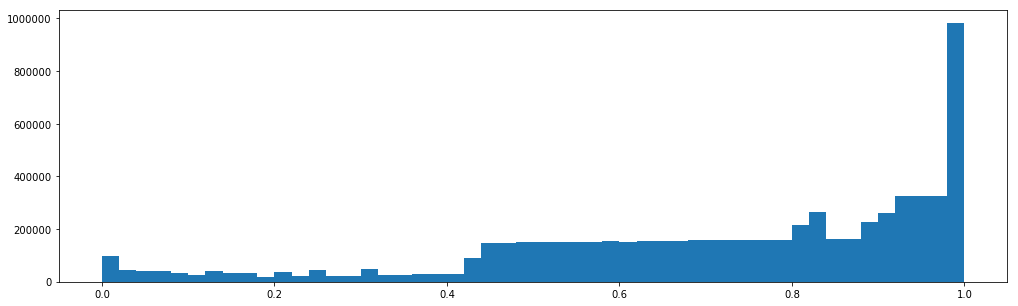

In [106]:
plt.hist(Wnorm.reshape(-1),bins=50);

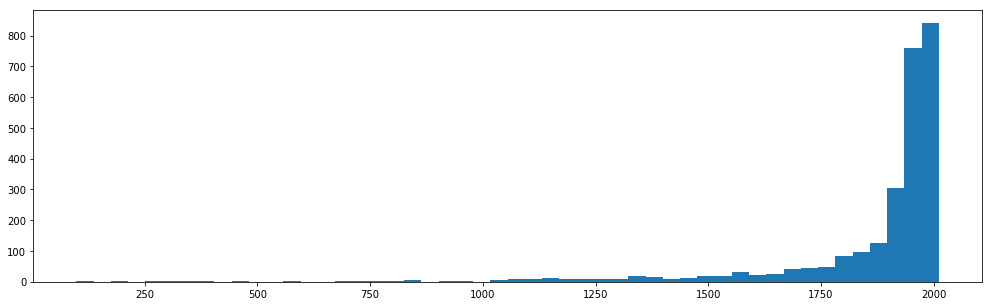

In [13]:
#Compute degree distribution 
degrees = np.zeros(len(Wnorm)) 
for i in range(0, len(Wnorm)):
    degrees[i] = sum(Wnorm[i])

plt.hist(degrees, bins=50);

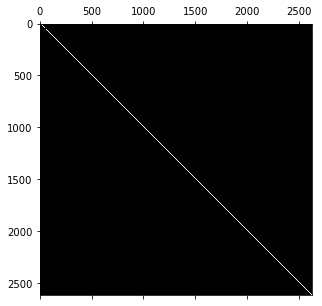

In [14]:
plt.spy(Wnorm)

In [18]:
sum(np.diag(Wnorm[:500][:500]))

0.0

In [68]:
len(Wnorm)

2621

In [19]:
laplacian_norm = scipy.sparse.csgraph.laplacian(Wnorm, normed = True)
print(laplacian_norm)

[[  1.00000000e+00  -4.22955374e-04  -4.27552009e-04 ...,  -2.87823217e-04
   -3.64949350e-04  -3.74725856e-04]
 [ -4.22955374e-04   1.00000000e+00  -1.86906604e-04 ...,  -2.63733425e-06
   -5.54686345e-04  -5.59871020e-04]
 [ -4.27552009e-04  -1.86906604e-04   1.00000000e+00 ...,  -5.46847947e-04
   -5.03985112e-04  -5.05091364e-04]
 ..., 
 [ -2.87823217e-04  -2.63733425e-06  -5.46847947e-04 ...,   1.00000000e+00
   -1.33181089e-04  -1.25406677e-04]
 [ -3.64949350e-04  -5.54686345e-04  -5.03985112e-04 ...,  -1.33181089e-04
    1.00000000e+00  -2.21574262e-04]
 [ -3.74725856e-04  -5.59871020e-04  -5.05091364e-04 ...,  -1.25406677e-04
   -2.21574262e-04   1.00000000e+00]]


In [34]:
G = graphs.Graph(Wnorm)
G.compute_laplacian('normalized')

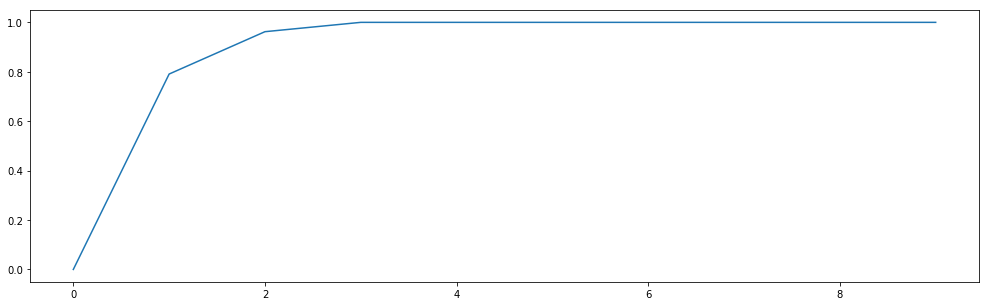

In [35]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

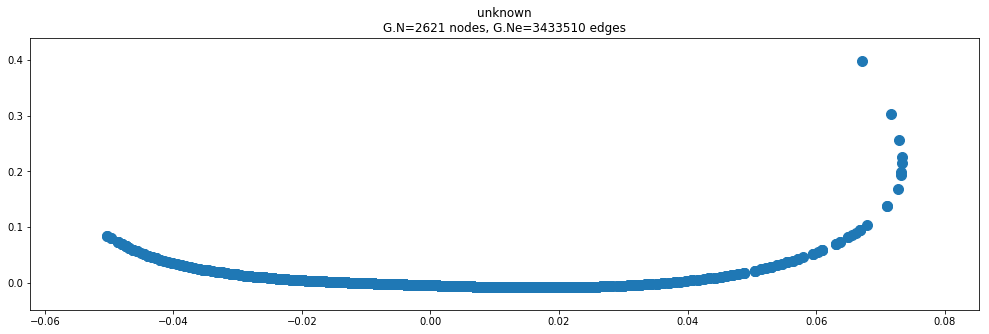

In [39]:
G.set_coordinates(G.U[:,1:3])
G.plot()

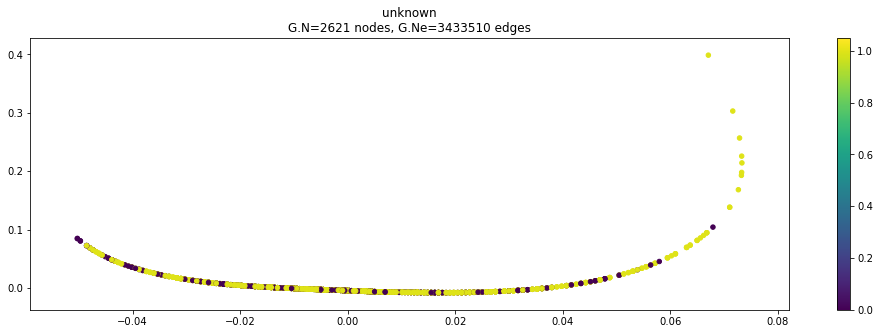

In [83]:
genres = preprocessing.LabelEncoder().fit_transform(dataset['success'])
G.plot_signal(genres, vertex_size=20)

In [48]:
maxW = W.max()
print(maxW)

233


####  Sparsification of the graph

In [126]:
NEIGHBORS = 1000

#sort the order of the weights
sort_order = np.argsort(Wnorm, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(Wnorm), len(Wnorm)))

for i in range (0, len(Wnorm)):  
    for j in range(0, len(Wnorm)):
        if (j >= len(Wnorm) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = Wnorm[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

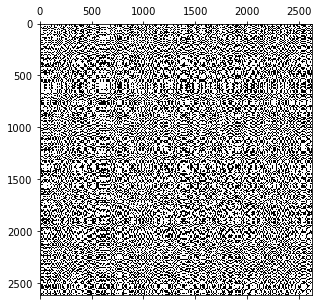

In [127]:
plt.spy(sorted_weights)

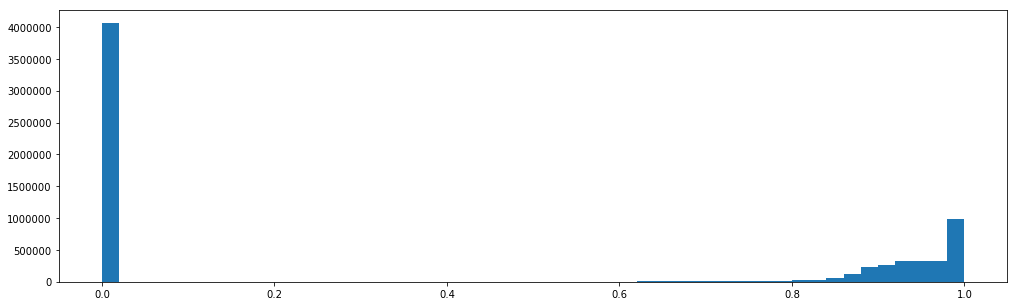

In [128]:
plt.hist(sorted_weights.reshape(-1), bins=50);

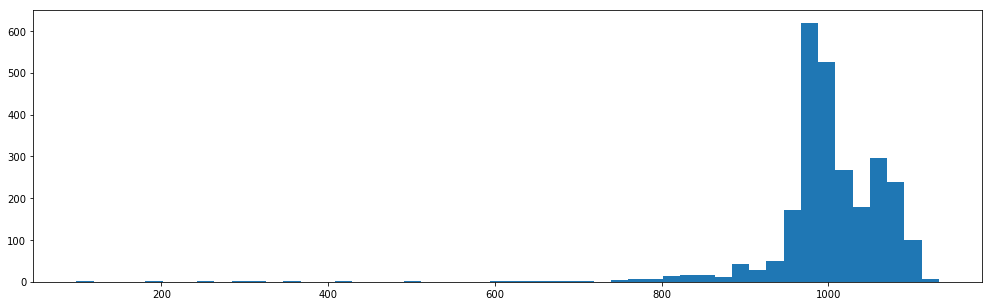

In [129]:
#Compute degree distribution 
degrees_spars = np.zeros(len(sorted_weights)) 
for i in range(0, len(sorted_weights)):
    degrees_spars[i] = sum(sorted_weights[i])

plt.hist(degrees_spars, bins=50);

In [131]:
NormW = pd.DataFrame(Wnorm)
NormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.000000,0.725465,0.839317,0.871749,0.937433,0.925518,0.998836,0.586162,0.839317,0.804369,...,0.484721,0.668366,0.705575,0.855873,0.987966,0.708768,0.728614,0.461914,0.728614,0.748150
1,0.725465,0.000000,0.317538,0.999806,0.047800,0.043933,0.901262,0.562334,0.996166,0.351152,...,0.783118,0.925518,0.445627,0.998560,0.804369,0.948405,0.423524,0.003663,0.958399,0.967380
2,0.839317,0.317538,0.000000,0.982189,0.939248,0.950067,0.801483,0.688668,0.992630,0.465031,...,0.886894,0.983185,0.301435,0.987966,0.685439,0.993271,0.545144,0.869262,0.996625,0.998836
3,0.871749,0.999806,0.982189,0.000000,0.521585,0.501462,0.708768,0.968718,0.465031,0.992630,...,0.822132,0.647914,0.998560,0.445627,0.822132,0.606763,0.999898,0.128862,0.586162,0.565608
4,0.937433,0.047800,0.939248,0.521585,0.000000,0.445627,0.270699,0.996166,0.562334,0.959901,...,0.899022,0.745054,0.043933,0.541889,0.190691,0.705575,0.988786,0.914806,0.685439,0.665110


In [133]:
NormSparsW = pd.DataFrame(sorted_weights)
NormSparsW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.000000,0.000000,0.000000,0.000000,0.937433,0.925518,0.998836,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.987966,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.999806,0.000000,0.000000,0.901262,0.000000,0.996166,0.000000,...,0.783118,0.925518,0.00000,0.998560,0.804369,0.948405,0.000000,0.000000,0.958399,0.967380
2,0.000000,0.000000,0.000000,0.982189,0.939248,0.950067,0.000000,0.000000,0.992630,0.000000,...,0.886894,0.983185,0.00000,0.987966,0.000000,0.993271,0.000000,0.869262,0.996625,0.998836
3,0.000000,0.999806,0.982189,0.000000,0.000000,0.000000,0.000000,0.968718,0.000000,0.992630,...,0.000000,0.000000,0.99856,0.000000,0.000000,0.000000,0.999898,0.000000,0.000000,0.000000
4,0.937433,0.000000,0.939248,0.000000,0.000000,0.000000,0.000000,0.996166,0.000000,0.959901,...,0.899022,0.000000,0.00000,0.000000,0.000000,0.000000,0.988786,0.914806,0.000000,0.000000


In [141]:
NormW.to_csv('Saved_Datasets/NormActTenuresW.csv', index=False)

In [142]:
NormSparsW.to_csv('Saved_Datasets/NormSparsActTenuresW.csv', index=False)

#### Compute Laplacian and graph embedding ####

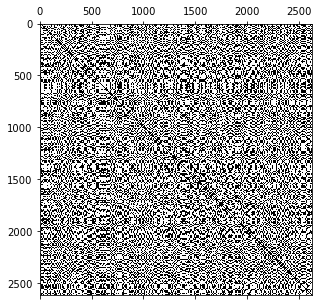

In [136]:
#reminder: L = D - W for weighted graphs
laplacian = np.diag(degrees) - Wnorm

#computation of the normalized Laplacian
laplacian_norm = scipy.sparse.csgraph.laplacian(sorted_weights, normed = True)

plt.spy(laplacian_norm);

In [137]:
eigenvalues, eigenvectors =  sparse.linalg.eigsh(laplacian_norm, k = 10, which = 'SM') 

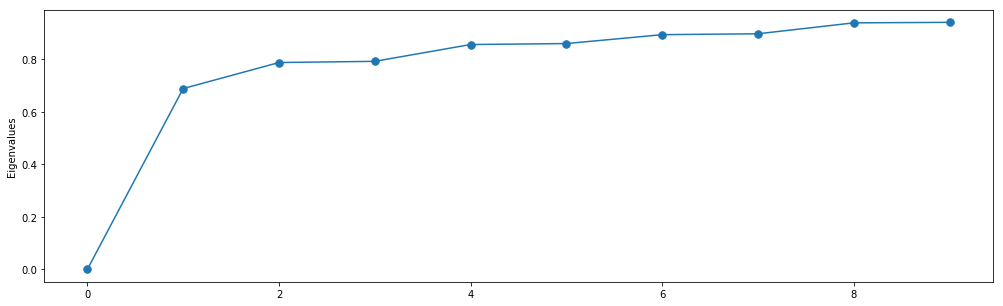

In [138]:
plt.plot(eigenvalues, '.-', markersize=15);
plt.xlabel('')
plt.ylabel('Eigenvalues')
plt.show()

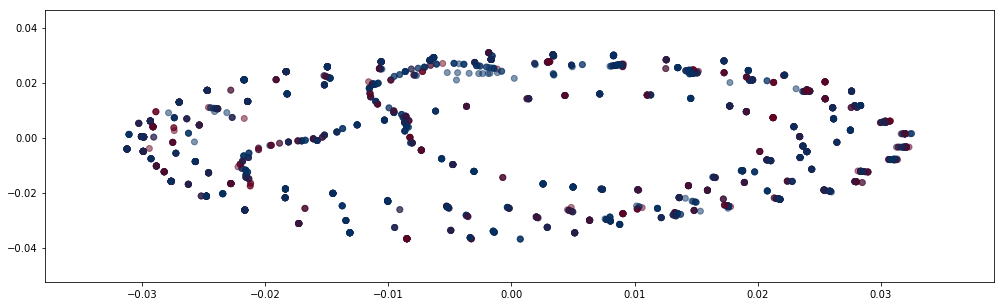

In [139]:
genres = preprocessing.LabelEncoder().fit_transform(dataset['success'])

x = eigenvectors[:, 2] 
y = eigenvectors[:, 3] 
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

###  3.3 3rd percentile normalization ###

In [7]:
val_75 = np.percentile(W,75)
print(val_75)

32.0


In [10]:
W_diff_norm = np.zeros(shape=(len(df_ten), len(df_ten)), dtype=float)
for i in range(0,len(df_ten)):
    for j in range(i,len(df_ten)):
        if W[i][j] == 0:
            W_diff_norm[i][j] = 1
        elif W[i][j] <= val_75:  
            W_diff_norm[i][j] = 1-(W[i][j])/(val_75)
        else:
            W_diff_norm[i][j] = 0

In [11]:
bigger = W_diff_norm.transpose() > W_diff_norm
W_diff_norm = W_diff_norm - W_diff_norm*bigger + W_diff_norm.transpose()*bigger
np.fill_diagonal(W_diff_norm, 0)

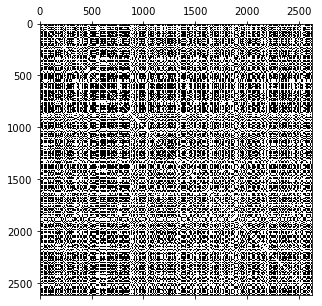

In [12]:
plt.spy(W_diff_norm)

In [13]:
DiffNormW = pd.DataFrame(W_diff_norm)
DiffNormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.00000,0.0,0.34375,0.28125,0.000,0.00000,0.00000,0.75000,0.34375,0.40625,...,0.90625,0.62500,0.00000,0.31250,0.00000,0.56250,0.53125,0.0000,0.53125,0.50000
1,0.00000,0.0,0.00000,0.00000,0.000,0.00000,0.21875,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.96875,0.00000,0.40625,0.00000,0.00000,0.0000,0.00000,0.00000
2,0.34375,0.0,0.00000,0.00000,0.125,0.09375,0.00000,0.59375,0.00000,0.93750,...,0.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.81250,0.0000,0.00000,0.00000
3,0.28125,0.0,0.00000,0.00000,0.000,0.00000,0.56250,0.03125,0.93750,0.00000,...,0.37500,0.65625,0.00000,0.96875,0.37500,0.71875,0.00000,0.0000,0.75000,0.78125
4,0.00000,0.0,0.12500,0.00000,0.000,0.96875,0.00000,0.00000,0.00000,0.06250,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.1875,0.00000,0.00000


In [14]:
DiffNormW.to_csv('Saved_Datasets/DiffNorm75ActTenW.csv', index=False)

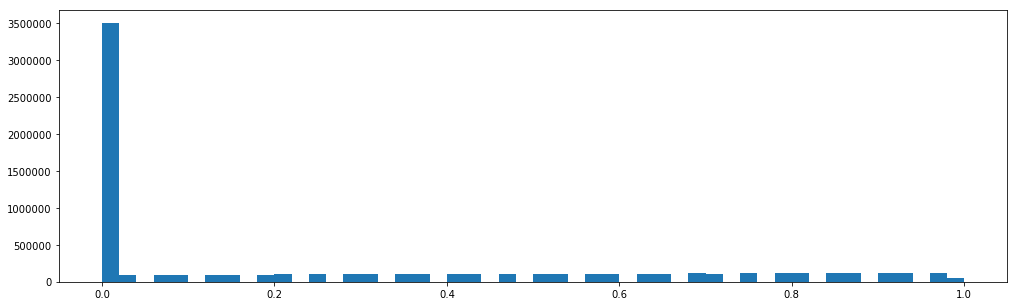

In [15]:
plt.hist(W_diff_norm.reshape(-1),bins=50);

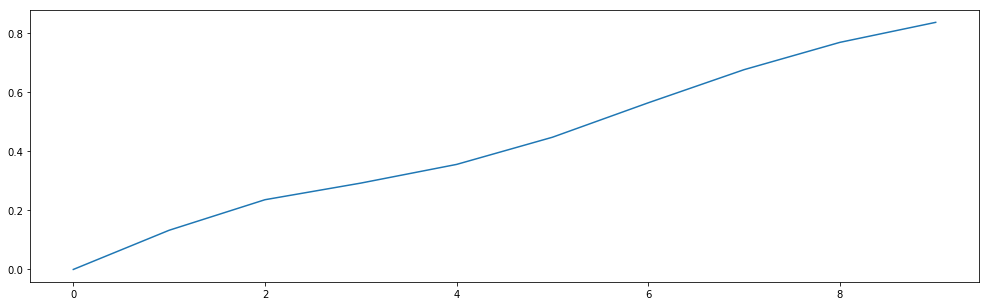

In [16]:
G = graphs.Graph(W_diff_norm)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

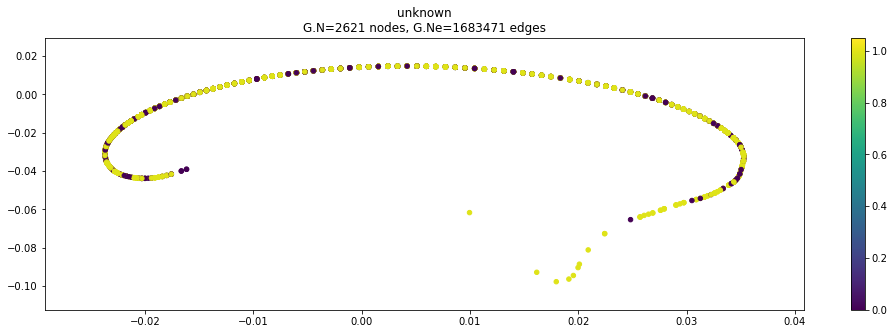

In [17]:
labels = preprocessing.LabelEncoder().fit_transform(df_ten['success'])
G.set_coordinates(G.U[:,1:3])
G.plot_signal(labels, vertex_size=20)

#### Sparsification of the weight matrix

In [21]:
NEIGHBORS = 200

#sort the order of the weights
sort_order = np.argsort(W_diff_norm, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(W_diff_norm), len(W_diff_norm)))

for i in range (0, len(W_diff_norm)):  
    for j in range(0, len(W_diff_norm)):
        if (j >= len(W_diff_norm) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = W_diff_norm[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

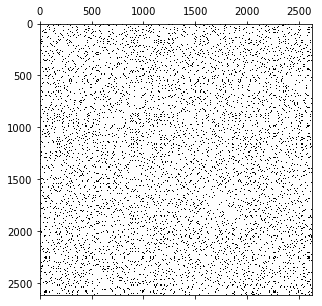

In [22]:
plt.spy(sorted_weights)

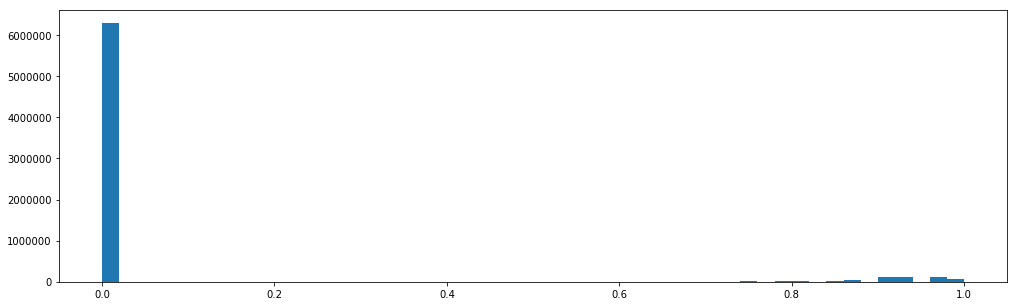

In [23]:
plt.hist(sorted_weights.reshape(-1),bins=50);

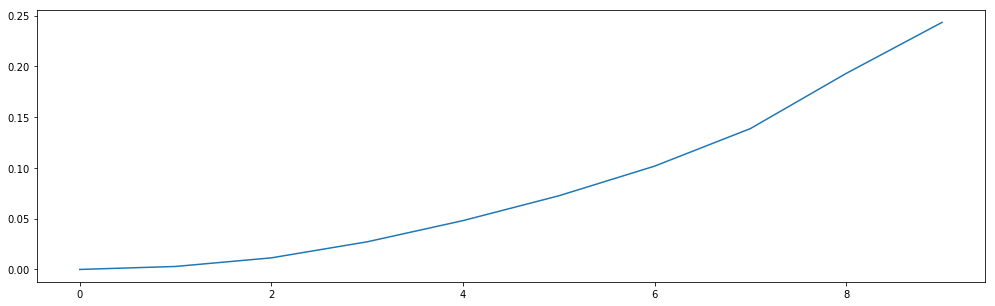

In [26]:
G = graphs.Graph(sorted_weights)
G.compute_laplacian('normalized')
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

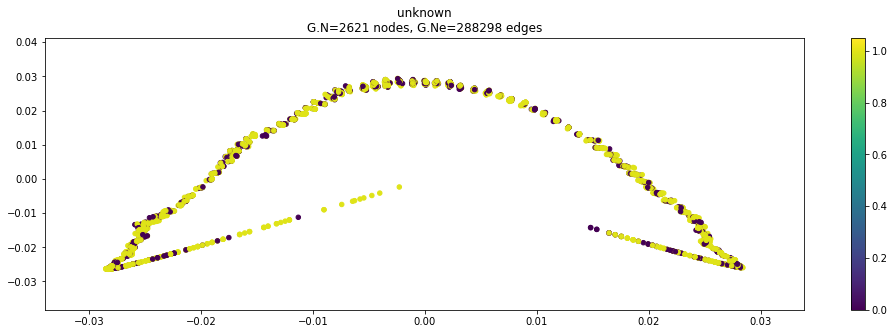

In [30]:
labels = preprocessing.LabelEncoder().fit_transform(df_ten['success'])
G.set_coordinates(G.U[:,1:3])
G.plot_signal(labels, vertex_size=20)